# Analyse ZAMG Daten mit Spark

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


## Burgenland

In [20]:
spark = SparkSession \
    .builder \
    .appName("Read Data") \
    .getOrCreate()

bl_raw = spark.read.option("delimiter", ";").csv("../data/zamg/zamg_burgenland.csv")
column_names=["location","alt",'deg', 'hum', 'wind_speed', 'wind_speed_max', 'rain', 'sun', 'press', 'timestamp']
bl_raw = bl_raw.toDF(*column_names)
print('before drop NA-values: ' + str(bl_raw.count()))
bl_raw = bl_raw.na.drop(subset=["location","timestamp","deg","rain"])
print('after drop NA-values: ' + str(bl_raw.count()))
bl_raw.printSchema()
bl_raw.show()

before drop NA-values: 8280
after drop NA-values: 8280
root
 |-- location: string (nullable = true)
 |-- alt: string (nullable = true)
 |-- deg: string (nullable = true)
 |-- hum: string (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- wind_speed_max: string (nullable = true)
 |-- rain: string (nullable = true)
 |-- sun: string (nullable = true)
 |-- press: string (nullable = true)
 |-- timestamp: string (nullable = true)

+-----------------+----+-----+----+---------------+--------------+------+-----+----------+-------------------+
|         location| alt|  deg| hum|     wind_speed|wind_speed_max|  rain|  sun|     press|          timestamp|
+-----------------+----+-----+----+---------------+--------------+------+-----+----------+-------------------+
|     Bruckneudorf|166m|21.1°|46 %| Südost, 9 km/h|       25 km/h|0.0 mm| 28 %|1007.0 hPa|2022-05-23 19:50:03|
|  Neusiedl am See|119m|21.4°|49 %|   Süd, 11 km/h|       27 km/h|0.0 mm| 32 %|1007.3 hPa|2022-05-23 19:50:03|
| 

In [3]:
# convert strings to correct datatypes
## datetime
bl = bl_raw.select(col("location") \
          , substring_index(col("deg"), "°", 1).cast('double').alias("deg")  \
          , substring_index(col("rain"), " mm", 1).cast('double').alias("rain")  \
          , to_timestamp(col("timestamp"),"yyyy-MM-dd HH:mm:ss").alias("timestamp"))
bl.printSchema()
bl.show()

root
 |-- location: string (nullable = true)
 |-- deg: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)

+-----------------+----+----+-------------------+
|         location| deg|rain|          timestamp|
+-----------------+----+----+-------------------+
|     Bruckneudorf|21.1| 0.0|2022-05-23 19:50:03|
|  Neusiedl am See|21.4| 0.0|2022-05-23 19:50:03|
|       Podersdorf|21.8| 0.0|2022-05-23 19:50:03|
|       Eisenstadt|21.6| 0.0|2022-05-23 19:50:03|
|            Andau|21.0| 0.0|2022-05-23 19:50:03|
|      Mattersburg|20.4| 0.0|2022-05-23 19:50:03|
|  Neudorf/Landsee|18.9| 0.0|2022-05-23 19:50:03|
|    Lutzmannsburg|21.2| 0.0|2022-05-23 19:50:03|
|        Bernstein|17.9| 0.0|2022-05-23 19:50:03|
|         Rechnitz|20.6| 0.0|2022-05-23 19:50:03|
|Bad Tatzmannsdorf|20.1| 0.0|2022-05-23 19:50:03|
|         Kroisegg|19.7| 0.0|2022-05-23 19:50:03|
|      Kleinzicken|20.8| 0.0|2022-05-23 19:50:03|
|       Wörterberg|19.6| 0.0|2022-05-23

In [4]:
bl.groupBy("location").agg(sum("rain"),avg('deg'),min('timestamp'),max('timestamp')).show()

+-----------------+------------------+------------------+-------------------+-------------------+
|         location|         sum(rain)|          avg(deg)|     min(timestamp)|     max(timestamp)|
+-----------------+------------------+------------------+-------------------+-------------------+
|  Neudorf/Landsee|109.49999999999997|17.607246376811606|2022-05-23 19:50:03|2022-06-15 18:50:03|
|          Güssing|             128.7|18.877536231884072|2022-05-23 19:50:03|2022-06-15 18:50:03|
|       Wörterberg|104.19999999999999| 17.78097826086957|2022-05-23 19:50:03|2022-06-15 18:50:03|
|Bad Tatzmannsdorf|114.60000000000001|18.276811594202915|2022-05-23 19:50:03|2022-06-15 18:50:03|
|        Bernstein|             134.6|16.415398550724632|2022-05-23 19:50:03|2022-06-15 18:50:03|
|    Lutzmannsburg|147.99999999999997|18.611594202898534|2022-05-23 19:50:03|2022-06-15 18:50:03|
|      Mattersburg|113.59999999999997|18.376992753623178|2022-05-23 19:50:03|2022-06-15 18:50:03|
|         Rechnitz| 

Umrechnen auf Tageswerte:

In [54]:
bl = bl.withColumn("date",to_date(col("timestamp")))
blDay = bl.groupBy("location", "date").agg(round(sum('rain'), 1), round(avg('deg'), 1))
column_names=['location', 'date', 'rain', 'deg']
blDay = blDay.toDF(*column_names).sort("location", "date")

blDay.printSchema()
blDay.show()

root
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- rain: double (nullable = true)
 |-- deg: double (nullable = true)

+--------+----------+----+----+
|location|      date|rain| deg|
+--------+----------+----+----+
|   Andau|2022-05-23| 0.0|19.1|
|   Andau|2022-05-24| 7.9|18.7|
|   Andau|2022-05-25| 1.8|17.6|
|   Andau|2022-05-26| 0.2|18.4|
|   Andau|2022-05-27| 0.0|21.2|
|   Andau|2022-05-28| 0.0|17.2|
|   Andau|2022-05-29| 0.0|12.9|
|   Andau|2022-05-30| 0.0|14.3|
|   Andau|2022-05-31| 0.0|16.8|
|   Andau|2022-06-01|11.4|20.0|
|   Andau|2022-06-02| 5.0|20.3|
|   Andau|2022-06-03| 0.0|22.2|
|   Andau|2022-06-04|10.9|24.5|
|   Andau|2022-06-05| 0.0|22.9|
|   Andau|2022-06-06|35.6|21.2|
|   Andau|2022-06-07| 0.0|20.7|
|   Andau|2022-06-08|12.1|19.5|
|   Andau|2022-06-09|14.0|18.2|
|   Andau|2022-06-10| 0.5|18.3|
|   Andau|2022-06-11| 0.0|21.2|
+--------+----------+----+----+
only showing top 20 rows



In [55]:
# Filter data by location and join to one table
guess = blDay.where(blDay["location"] == "Güssing")
neus =  blDay.where(blDay["location"] == "Neusiedl am See")
blUnion = guess.union(neus)
blUnion.groupby('location').count().show()

## Niederösterreich

In [25]:
spark = SparkSession \
    .builder \
    .appName("Read Data") \
    .getOrCreate()

no_raw = spark.read.option("delimiter", ";").csv("../data/zamg/zamg_niederoesterreich.csv")
column_names=["location","alt",'deg', 'hum', 'wind_speed', 'wind_speed_max', 'rain', 'sun', 'press', 'timestamp']
no_raw = no_raw.toDF(*column_names)
print('before drop NA-values: ' + str(no_raw.count()))
no_raw = no_raw.na.drop(subset=["location","timestamp","deg","rain"]) # only one location
print('after drop NA-values: ' + str(no_raw.count()))
no_raw.printSchema()
no_raw.show()

before drop NA-values: 33505
after drop NA-values: 33504
root
 |-- location: string (nullable = true)
 |-- alt: string (nullable = true)
 |-- deg: string (nullable = true)
 |-- hum: string (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- wind_speed_max: string (nullable = true)
 |-- rain: string (nullable = true)
 |-- sun: string (nullable = true)
 |-- press: string (nullable = true)
 |-- timestamp: string (nullable = true)

+----------------+----+-----+----+-----------------+--------------+------+-----+----------+-------------------+
|        location| alt|  deg| hum|       wind_speed|wind_speed_max|  rain|  sun|     press|          timestamp|
+----------------+----+-----+----+-----------------+--------------+------+-----+----------+-------------------+
|        Litschau|557m|21.7°|43 %| Nordwest, 8 km/h|       31 km/h|0.0 mm| 86 %|1016.9 hPa|2022-05-21 16:50:03|
|          Weitra|570m|21.6°|38 %|    West, 17 km/h|       43 km/h|0.0 mm| 99 %|1016.9 hPa|2022-05-21 16:50

In [26]:
# convert strings to correct datatypes
## datetime
no = no_raw.select(col("location") \
          , substring_index(col("deg"), "°", 1).cast('double').alias("deg")  \
          , substring_index(col("rain"), " mm", 1).cast('double').alias("rain")  \
          , to_timestamp(col("timestamp"),"yyyy-MM-dd HH:mm:ss").alias("timestamp"))
no.printSchema()
no.show()

root
 |-- location: string (nullable = true)
 |-- deg: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)

+----------------+----+----+-------------------+
|        location| deg|rain|          timestamp|
+----------------+----+----+-------------------+
|        Litschau|21.7| 0.0|2022-05-21 16:50:03|
|          Weitra|21.6| 0.0|2022-05-21 16:50:03|
|          Zwettl|21.9| 0.0|2022-05-21 16:50:03|
|     Raabs/Thaya|22.5| 0.0|2022-05-21 16:50:03|
|     Allentsteig|20.7| 0.0|2022-05-21 16:50:03|
|            Horn|23.3| 0.0|2022-05-21 16:50:03|
|    Gars am Kamp|23.6| 0.0|2022-05-21 16:50:03|
|      Langenlois|25.4| 0.0|2022-05-21 16:50:03|
|           Krems|25.0| 0.0|2022-05-21 16:50:03|
|        Bärnkopf|17.9| 0.0|2022-05-21 16:50:03|
|       Jauerling|18.5| 0.0|2022-05-21 16:50:03|
|            Retz|23.1| 0.0|2022-05-21 16:50:03|
|Laa an der Thaya|25.3| 0.0|2022-05-21 16:50:03|
|        Poysdorf|24.0| 0.0|2022-05-21 16:50:03|
|     

In [27]:
no.groupBy("location").agg(sum("rain"),avg('deg'),min('timestamp'),max('timestamp')).show()

+--------------------+------------------+------------------+-------------------+-------------------+
|            location|         sum(rain)|          avg(deg)|     min(timestamp)|     max(timestamp)|
+--------------------+------------------+------------------+-------------------+-------------------+
|           Hohe Wand|             124.5|  14.0698175787728|2022-05-21 16:50:03|2022-06-15 18:50:02|
|         Allentsteig|108.59999999999998| 15.22703150912106|2022-05-21 16:50:03|2022-06-15 18:50:02|
|          Langenlois| 78.29999999999997|18.194195688225555|2022-05-21 16:50:03|2022-06-15 18:50:02|
|            Poysdorf|35.300000000000004|18.203482587064713|2022-05-21 16:50:03|2022-06-15 18:50:02|
|                Retz|             112.0|17.600000000000012|2022-05-21 16:50:03|2022-06-15 18:50:02|
|      Semmering/Pass|136.19999999999993| 13.56451077943616|2022-05-21 16:50:03|2022-06-15 18:50:02|
|          Pottschach| 93.09999999999997|17.731343283582085|2022-05-21 16:50:03|2022-06-15 

Umrechnen auf Tageswerte:

In [28]:
no = no.withColumn("date",to_date(col("timestamp")))
noDay = no.groupBy("location", "date").agg(round(sum('rain'), 1), round(avg('deg'), 1))
column_names=['location', 'date', 'rain', 'deg']
noDay = noDay.toDF(*column_names).sort("location", "date")

noDay.printSchema()
noDay.show()

root
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- rain: double (nullable = true)
 |-- deg: double (nullable = true)

+-----------+----------+----+----+
|   location|      date|rain| deg|
+-----------+----------+----+----+
|Allentsteig|2022-05-21| 0.0|17.4|
|Allentsteig|2022-05-22| 0.0|14.5|
|Allentsteig|2022-05-23| 0.0|14.4|
|Allentsteig|2022-05-24| 4.6|15.1|
|Allentsteig|2022-05-25|16.7|12.5|
|Allentsteig|2022-05-26| 0.0|14.8|
|Allentsteig|2022-05-27| 0.0|15.4|
|Allentsteig|2022-05-28| 0.0|11.8|
|Allentsteig|2022-05-29| 9.9| 8.3|
|Allentsteig|2022-05-30| 0.0|10.1|
|Allentsteig|2022-05-31| 1.7|13.7|
|Allentsteig|2022-06-01| 5.8|15.5|
|Allentsteig|2022-06-02| 0.2|16.3|
|Allentsteig|2022-06-03| 0.0|18.2|
|Allentsteig|2022-06-04|21.6|18.6|
|Allentsteig|2022-06-05|16.9|18.2|
|Allentsteig|2022-06-06| 0.8|18.0|
|Allentsteig|2022-06-07|11.8|15.3|
|Allentsteig|2022-06-08| 0.3|16.2|
|Allentsteig|2022-06-09| 3.5|14.1|
+-----------+----------+----+----+
only show

In [63]:
# Filter data by location and join to one table
krems = noDay.where(noDay["location"] == "Krems")
poys =  noDay.where(noDay["location"] == "Poysdorf")
noUnion = krems.union(poys)
noUnion.groupby('location').count().show()

+--------+-----+
|location|count|
+--------+-----+
|   Krems|   26|
|Poysdorf|   26|
+--------+-----+



In [68]:
# union bl and no and save to file
all = blUnion.union(noUnion)
all = all.toPandas()
all.to_hdf('../data/zamg/zamg.h5', key='all', mode='w')

/tmp/ipykernel_71/1558406364.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['location', 'date'], dtype='object')]

  all.to_hdf('../data/zamg/zamg.h5', key='all', mode='w')


In [69]:
t = pd.read_hdf('../data/zamg/zamg.h5') 
t

,location,date,rain,deg
0,Güssing,2022-05-23,0.0,19.6
1,Güssing,2022-05-24,15.1,19.7
2,Güssing,2022-05-25,16.5,17.6
3,Güssing,2022-05-26,0.0,18.1
4,Güssing,2022-05-27,12.0,20.1
...,...,...,...,...
95,Poysdorf,2022-06-11,0.0,20.4
96,Poysdorf,2022-06-12,0.0,21.2
97,Poysdorf,2022-06-13,0.1,18.4
98,Poysdorf,2022-06-14,0.0,17.2


<AxesSubplot:xlabel='date', ylabel='deg'>

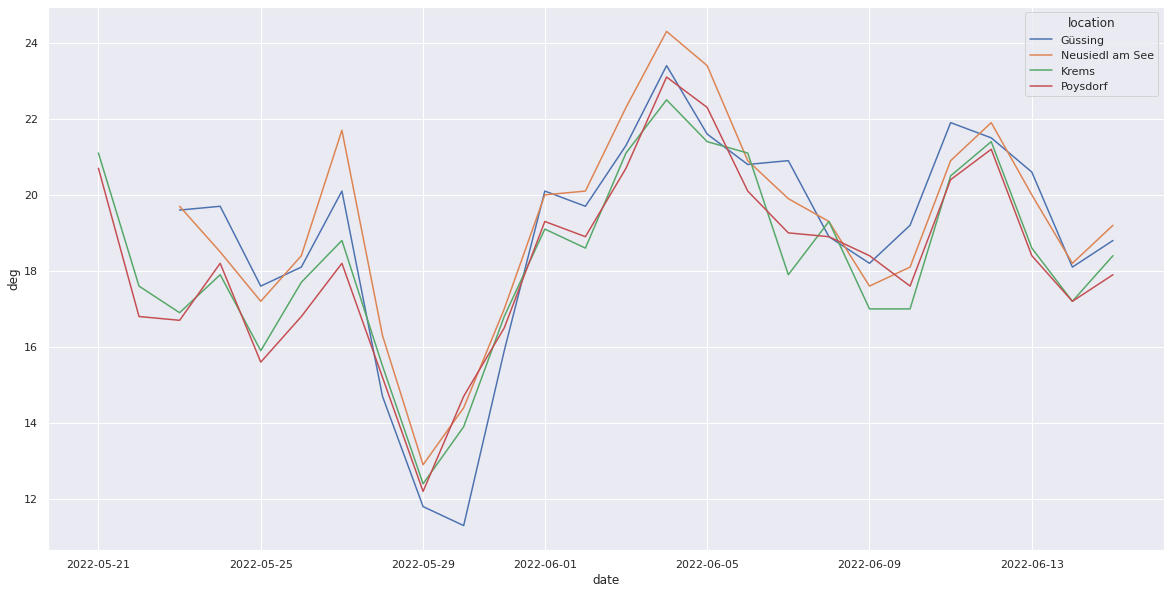

In [78]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=all, x="date", y="deg", hue="location")

<AxesSubplot:xlabel='date', ylabel='rain'>

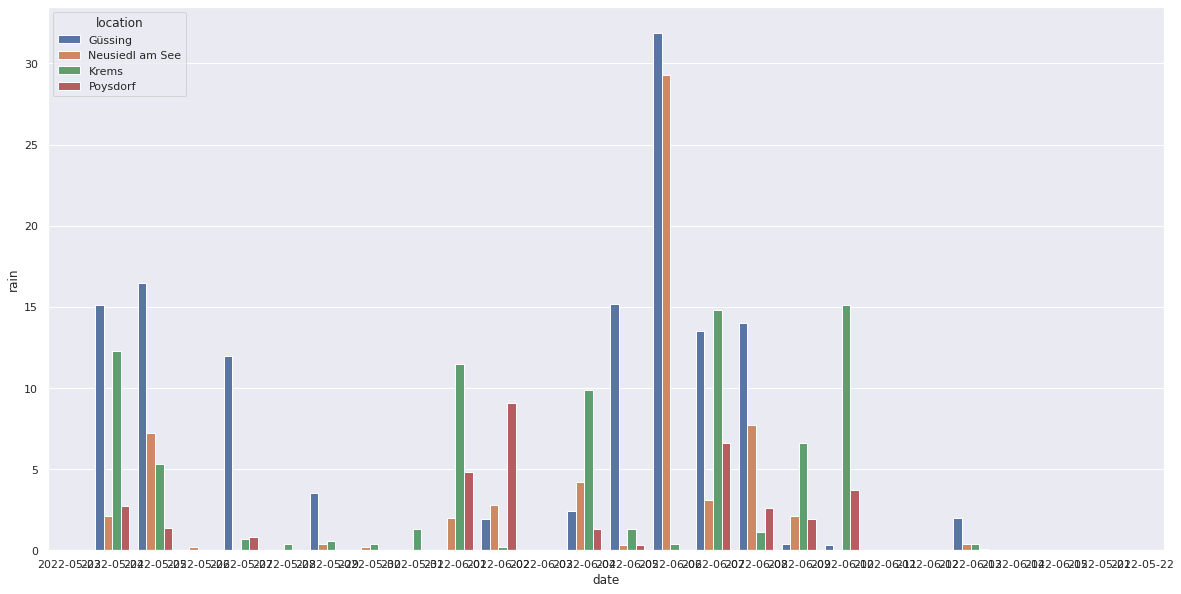

In [81]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(data=all, x="date", y="rain", hue="location")